In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import cv2
from lpproj import LocalityPreservingProjection

from IPython.lib import backgroundjobs as bg
jobs = bg.BackgroundJobManager()

# EigenFaces

In [3]:
from clamv import *
img = get_images(min_faces_per_person=70)
X = img.data
y = img.target

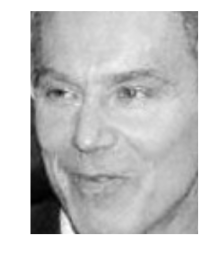

In [4]:
plt.axis('off')
show(img.images[1], cmap=plt.get_cmap('gray'))

In [5]:
pca = PCA(n_components=10).fit(X, y)

In [6]:
eigenfaces = pca.components_.reshape(pca.components_.shape[0], img.images.shape[1], -1)

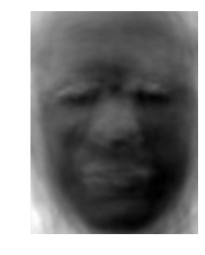

In [7]:
plt.axis('off')
plt.imshow(eigenfaces[0], cmap=plt.get_cmap('gray'))

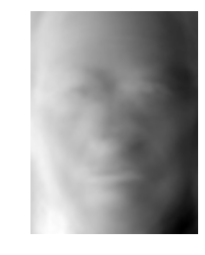

In [10]:
plt.axis('off')
plt.imshow(eigenfaces[1], cmap=plt.get_cmap('gray'))

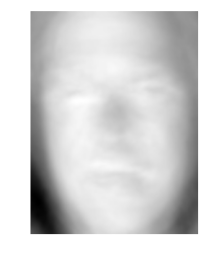

In [13]:
plt.axis('off')
plt.imshow(eigenfaces[2], cmap=plt.get_cmap('gray'))

# Color
http://ac.els-cdn.com/S0167865502003835/1-s2.0-S0167865502003835-main.pdf?_tid=d5fda8d6-a475-11e6-8542-00000aab0f6b&acdnat=1478473849_ce42c7d93d2c665f410c24539c1fafdf


In [20]:
rgb2yuv = np.array([[0.299, 0.587, 0.114],
                    [-0.14713, -0.28886, 0.436],
                    [0.615, -0.51499, -0.10001]])
yuv = np.dot(imgs, rgb2yuv.T)

In [21]:
X_train_all, X_test_all, y_train, y_test = train_test_split(
    yuv, d.target, test_size=0.25, random_state=42)

In [22]:
def subsample(X):
    Y = X[:, :, :, 0]
    U = X[:, ::2, ::2, 1]
    V = X[:, ::2, ::2, 2]
    return (Y, U, V)

X_train = subsample(X_train_all)
X_test = subsample(X_test_all)

In [23]:
n_components = 150
X_train_pca = []
X_test_pca = []

for i in range(3):
    X = X_train[i]
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    Xt = X_test[i]
    Xt = Xt.reshape(Xt.shape[0], Xt.shape[1] * Xt.shape[2])
    pca = PCA(n_components=n_components, svd_solver='randomized',
      whiten=True).fit(X)
    X_train_pca.append(pca.transform(X))
    X_test_pca.append(pca.transform(Xt))

In [19]:
def flatten(X):
    X = np.swapaxes(np.swapaxes(X, 0, 1), 1, 2)
    return X.reshape(X.shape[0], X.shape[1] * X.shape[2])

X_train_pca = flatten(X_train_pca)
X_test_pca = flatten(X_test_pca)

In [21]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

In [23]:
clf = clf.fit(X_train_pca, y_train)
print(clf.best_estimator_)

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [24]:
y_pred = clf.predict(X_test_pca)

In [25]:
print(classification_report(y_test, y_pred, target_names=d.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.83      0.77      0.80        13
     Colin Powell       0.86      0.93      0.90        60
  Donald Rumsfeld       0.66      0.70      0.68        27
    George W Bush       0.94      0.90      0.92       146
Gerhard Schroeder       0.96      0.88      0.92        25
      Hugo Chavez       0.93      0.87      0.90        15
       Tony Blair       0.82      0.89      0.85        36

      avg / total       0.89      0.88      0.88       322

